# GRAPH COARSENING WITH NEURAL NETWORKS 
## Giorgio Macauda, Peter Buttaroni, Shubhayu (Shubho) Das

In [ ]:
import torch
try:
  import torch_geometric
except:
  !pip -q install torch-scatter     -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
  !pip -q install torch-sparse      -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
  !pip -q install torch-cluster     -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
  !pip -q install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
  !pip -q install torch-geometric
  import torch_geometric
from torch_geometric.utils.random import erdos_renyi_graph, barabasi_albert_graph
import numpy as np
import sys
import os 
import pickle
import matplotlib.pyplot as plt
import random
import math
 
from scipy.sparse.csgraph import shortest_path
from scipy.sparse import csr_matrix
 
 
from google.colab import drive
folder = '/content/drive/MyDrive/USI/GDLProject/'
drive.mount('/content/drive/', force_remount=True)
 
sys.path.append(folder)

Mounted at /content/drive/


## CLASS AND FUNCTIONS

In [ ]:
def eigen_analysis(matrix):
  '''Given a matrix, it returns the first 40 eigenvalues 
     and the corresponding eigenvectors'''
  w, v = np.linalg.eig(matrix)
  idx = np.argsort(w)
  return w[idx[:40]], v[:, idx[:40]]

In [ ]:
class SyntheticGraph():
  '''This class implements a single Synthetic Graph'''
  def __init__(self, pathname):
    '''The pathname is the path where there is thenpickle file with the graphs'''
    with open(pathname, 'rb') as f:
      adj_matrix = torch_geometric.utils.to_dense_adj(pickle.load(f))[0]
      f.close()
    self.name = pathname.split("/")[-1]
    self.adjacency_matrix = adj_matrix
    self.eigenvalues, self.eigenvectors = eigen_analysis(self.getCombinatorialLaplacian())
    self.n_nodes = self.adjacency_matrix.shape[0]
    self.compute_node_features()
 
  def getCombinatorialLaplacian(self):
    '''Returns the combinatorial Laplacian of the graph'''
    return torch.diag(torch.sum(self.adjacency_matrix, axis = 1)) - self.adjacency_matrix
 
  def get_adj_list(adj):
    ''' Given an adjacency matrix it returns a dictionary with the adjacency list '''
    n = adj.shape[0]
    adj_list = dict((k, []) for k in range(n))
    pos_x, pos_y = np.where(adj != 0)
    for i in range(len(pos_x)):
        adj_list[pos_x[i]].append(pos_y[i])
    return adj_list
 
  def compute_node_features(self):
    '''It computes the node features defined using the local degree profile (LDP)
       as explained in "A simple yet effective baseline for non-attribute 
       graph classification" (Cai & Wang, 2018)'''
    self.node_features = []
    degree = np.sum(self.adjacency_matrix.numpy(), axis = 1)
    adj_dict = SyntheticGraph.get_adj_list(self.adjacency_matrix)
    node_features = []
    for node in range(self.n_nodes):
      neighborhood_degree = degree[adj_dict[node]]
      self.node_features.append([degree[node],
                                  min(neighborhood_degree, default = 0),
                                  max(neighborhood_degree, default = 0),
                                  np.mean(neighborhood_degree) if len(neighborhood_degree) != 0 else 0,
                                  np.std(neighborhood_degree) if len(neighborhood_degree) != 0 else 0])
    self.node_features=torch.tensor(self.node_features)
 
  def _import(pathname):
    '''Given a path it import the graph stored as pickle file at that path'''
    folder = "/".join(pathname.split("/")[:-1])
    if not os.path.exists(folder):
      raise Exception("Folder does not exist")
    with open(pathname, 'rb') as f:
      graph = pickle.load(f)
    f.close()
    return graph
 
  def export(self, pathname):
    '''Given a path, it exports the graph as pickle file'''
    folder = "/".join(pathname.split("/")[:-1])
    if not os.path.exists(folder):
      os.makedirs(folder)
    with open(pathname, 'wb') as f:
      pickle.dump(self, f)
    f.close()
 
  def importAll(graph_type="erdos"):
    graphs = []
    for i in range(25):
      graphs.append(SyntheticGraph._import(folder+"graphs/"+graph_type+"/synthetic_graph_"+str(i)+".syn"))
    return graphs

In [ ]:
class ReducedGraph():
  '''This class implements a single Reduced Graph'''
  def __init__(self, graph, pathname):
    with open(pathname, 'rb') as f:
      self.mapping = pickle.load(f)
      f.close()
 
    self.n_supernodes = len(self.mapping.keys())
    self.edges = ReducedGraph.getEdges(graph, self.mapping)
    self.n_edges = len(self.edges)
    self.weight_matrix = self.compute_reduced(graph)
    self.computeProjection(graph)
    self.combinatorialEigenValues, _ = eigen_analysis(self.getCombinatorialLaplacian())
    self.doublyWeightedEigenValues, _ = eigen_analysis(self.getDoublyWeightedLaplacian())
 
  def getEdges(graph, mapping):
    '''Given the mapping, this function returns the edge_index list that represents 
       all the edges in the reduced graph. An edge between two supernodes is created 
       iff there is at least one cross edge between two nodes belonging to the two 
       supernodes'''
    edges = []
    n_edges = 0
    n_supernodes = len(mapping.keys())
    for i in range(n_supernodes-1):
      for j in range(i+1, n_supernodes):
        found = False
        if(i != j and not found):
          for l in mapping[i]:
            for p in mapping[j]:
              if(graph.adjacency_matrix[l,p]!=0):
                edges.append((i,j))
                n_edges += 1
                found = True
                break
            if(found): break
    return edges
 
  def computeProjection(self, graph):
    '''This function compute the projection matrix PI as described in the paper 
       Graph Coarsening with Neural Networks (Cai & al. 2021)'''
    self.P = torch.zeros((self.n_supernodes, graph.n_nodes))
    self.P_plus = torch.zeros((graph.n_nodes, self.n_supernodes))
    self.Gamma = torch.zeros((self.n_supernodes, self.n_supernodes))
    for key in self.mapping.keys():
        size_cluster = len(self.mapping[key])
        self.P[key, self.mapping[key]] = 1/size_cluster
        self.P_plus[self.mapping[key], key] = 1
        self.Gamma[key, key] = size_cluster
    self.PI = self.P_plus @ self.P
 
  def compute_reduced(self, graph):
    '''Given a graph, it returns the weight matrix of the reduced graph'''
    weight_matrix = torch.zeros((self.n_supernodes, self.n_supernodes))
    for edge in self.edges:
      weight_matrix[edge[0], edge[1]] = torch.sum(graph.adjacency_matrix[self.mapping[edge[0]],:][:,self.mapping[edge[1]]])
      weight_matrix[edge[1], edge[0]] = weight_matrix[edge[0], edge[1]]
    return weight_matrix
 
  def getDoublyWeightedLaplacian(self):
    '''It returns the Doubly Weighted Laplacian of the reduced graph'''
    laplacian = self.getCombinatorialLaplacian()
    gamma_prime = torch.diag(torch.pow(torch.diag(self.Gamma), -0.5))
    laplacian =  gamma_prime @ laplacian @ gamma_prime
    return laplacian
 
  def getCombinatorialLaplacian(self):
    '''It returns the Combinatorial Laplacian of the reduced graph'''
    return torch.diag(torch.sum(self.weight_matrix, axis = 1)) - self.weight_matrix
 
  def export(self, pathname):
    '''Given a path, it exports the graph as pickle file'''
    folder = "/".join(pathname.split("/")[:-1])
    if not os.path.exists(folder):
      os.makedirs(folder)
    with open(pathname, 'wb') as f:
      pickle.dump(self, f)
    f.close()
 
  def _import(pathname):
    folder = "/".join(pathname.split("/")[:-1])
    if not os.path.exists(folder):
      raise Exception("Folder does not exist")
    with open(pathname, 'rb') as f:
      red_graph = pickle.load(f)
    f.close()
    return red_graph

In [ ]:
class GINConv(torch.nn.Module):
  '''This class implements the GIN convolutional layer as described in the paper 
     Graph Coarsening with Neural Networks (Cai & al. 2021)'''
  def __init__(self, node_size):
    super().__init__()
    self.linear1 = torch.nn.Linear(node_size, node_size)
    self.leak_relu1 = torch.nn.LeakyReLU()
    # self.leak_relu1 = torch.nn.ReLU()
    self.linear2 = torch.nn.Linear(node_size, node_size)
    # self.leak_relu2 = torch.nn.ReLU()
    self.leak_relu2 = torch.nn.LeakyReLU()
 
  def forward(self, A, X, E):
    X = self.linear1(X + A @ X + E)
    X = self.leak_relu1(X)
    X = self.linear2(X)
    X = self.leak_relu2(X)
    return X
 
class GNN(torch.nn.Module):
  '''This class implements the GOREN GNN as described in the paper 
     Graph Coarsening with Neural Networks (Cai & al. 2021)'''
  def __init__(self, node_size, n_layers, lr, pathname = None):
    super().__init__()
 
    self.linear_edges = torch.nn.Linear(1, node_size)
    self.linear_nodes = torch.nn.Linear(5, node_size)
 
    self.convs = torch.nn.ModuleList()
    for _ in range(n_layers):
        self.convs.append(GINConv(node_size))
    self.linear = torch.nn.Linear(node_size, 1)
 
    self.leak_relu = torch.nn.LeakyReLU()
    # self.leak_relu = torch.nn.ReLU()
 
    if(pathname != None):
        try:
          self.load_state_dict(torch.load(pathname))
          print("Loading model: ", pathname)
        except:
          print("No model found. New one created.")
 
    self.optimizer = torch.optim.Adam(self.parameters(), lr = lr)
 
  def export(self, pathname):
    '''Given a path, this function saves the model at that path'''
    folder = "/".join(pathname.split("/")[:-1])
    if not os.path.exists(folder):
      os.makedirs(folder)
    print("Exporting model: ", pathname)
    torch.save(self.state_dict(), pathname)
 
  def _import(self, pathname):
    '''Given a path, this function imports the model at that path'''
    print("Loading model: ", pathname)
    self.load_state_dict(torch.load(pathname))
    
  def forward(self, A, X, E):
    E = self.linear_edges(E)
    X = self.linear_nodes(X)
 
    for layer in self.convs:
        X = layer(A, X, E)
 
    X = self.linear(X.mean(axis = 1))
    X = 1 + self.leak_relu(X)
    return X
 
  def quadratic_loss(graph, reducedGraph, w_hat):
    '''Given a graph, the corresponding reduced graph, and the weight matrix 
       predicted, it returns the quadratic loss'''
    d_hat = torch.diag(torch.sum(w_hat, axis = 1))
    L_hat = d_hat - w_hat
    P_eig = reducedGraph.P @ graph.eigenvectors
    loss = 0
    # 40 = number of the eigenvectors considered in the loss
    for i in range(40):
      quadratic_original = (graph.eigenvectors[:,i].T @ graph.getCombinatorialLaplacian().detach().numpy() @ graph.eigenvectors[:,i])
      quadratic_reconstruct = (P_eig[:,i].T @ L_hat @ P_eig[:,i])
      loss += torch.abs(quadratic_original - quadratic_reconstruct)
    return loss/40
 
  def rayleigh_loss(graph, reducedGraph, w_hat):
    '''Given a graph, the corresponding reduced graph, and the weight matrix 
       predicted, it returns the rayleigh loss'''
    d_hat = torch.diag(torch.sum(w_hat, axis = 1))
    gamma_prime = torch.diag(torch.pow(torch.diag(reducedGraph.Gamma), -0.5))
    L_hat = gamma_prime @ (d_hat - w_hat) @ gamma_prime
    P_italic = gamma_prime @ reducedGraph.P_plus.T
    P_eig = P_italic @ graph.eigenvectors
    loss = 0
    # 40 = number of the eigenvectors considered in the loss
    for i in range(40):
      rayleigh_original = ((graph.eigenvectors[:,i].T @ graph.getCombinatorialLaplacian().detach().numpy() @ graph.eigenvectors[:,i])/
                            (graph.eigenvectors[:,i].T @ graph.eigenvectors[:,i]))
      rayleigh_reconstruct = ((P_eig[:,i].T @ L_hat @ P_eig[:,i])/(P_eig[:,i].T @ P_eig[:,i]))
      loss += torch.abs(rayleigh_original - rayleigh_reconstruct)
    return loss/40
 
  def eigen_error(graph, reducedGraph, w_hat, laplacian="combinatorial"):
    '''Given a graph, the corresponding reduced graph, and the weight matrix 
       predicted, it returns the eigen error'''
    d_hat = torch.diag(torch.sum(w_hat, axis = 1))
    l_hat = d_hat - w_hat
 
    if(laplacian == "doubly_weighted"):
      gamma_prime = torch.diag(torch.pow(torch.diag(reducedGraph.Gamma), -0.5))
      l_hat = gamma_prime @ l_hat @ gamma_prime

    eigenvalues, eigenvectors = eigen_analysis(l_hat.detach().numpy())
    eigenerror = 0
    # 40 = number of the eigenvectors considered in the loss
    for i in range(1, 40):
      eigenerror += (abs(eigenvalues[i] - graph.eigenvalues[i]) / graph.eigenvalues[i])
    return eigenerror/39, eigenvalues
 
  def forwardOnGraph(self, dataset, graphIndex, w_hat, loss="quadratic_loss"):
    loss_function = {"quadratic_loss": GNN.quadratic_loss, "rayleigh_loss": GNN.rayleigh_loss}
 
    tmp = 0
    with torch.enable_grad():
      counter = 0
      batches = dataset.getNumberOfBatches(graphIndex)
 
      for i in range(batches):
        counter += 1
        A, X, E, x, y = dataset.getNextBatch(graphIndex)
        output = self(A, X, E)
        out = output.squeeze(0).squeeze(0)
        w_hat[x, y] = out
        w_hat[y, x] = out
 
        if (counter == 600 or i == batches-1):
          counter = 0
          LOSS = loss_function[loss](dataset.graphs[graphIndex], dataset.reducedGraphs[graphIndex], w_hat)
          LOSS.backward()
          self.optimizer.step()
          self.optimizer.zero_grad()
          w_hat = w_hat.detach()
          tmp += LOSS.item()
 
    return w_hat, tmp/math.ceil(dataset.getNumberOfBatches(graphIndex)/600+1)
 
  def predictOnGraph(self, dataset, graphIndex, loss="quadratic_loss", laplacian="combinatorial"):
    loss_function = {"quadratic_loss": GNN.quadratic_loss, "rayleigh_loss": GNN.rayleigh_loss}
    with torch.no_grad():
      w_hat = torch.zeros(dataset.reducedGraphs[graphIndex].n_supernodes, dataset.reducedGraphs[graphIndex].n_supernodes)
      for i in range(dataset.getNumberOfBatches(graphIndex)):
        A, X, E, x, y = dataset.getNextBatch(graphIndex)
        output = self(A, X, E)
        out = output.squeeze(0).squeeze(0)
        w_hat[x, y] = out
        w_hat[y, x] = out
 
      LOSS = loss_function[loss](dataset.graphs[graphIndex], dataset.reducedGraphs[graphIndex], w_hat)
    eigen_error, eigenvalues = GNN.eigen_error(dataset.graphs[graphIndex], dataset.reducedGraphs[graphIndex], w_hat, laplacian=laplacian)
    return w_hat, LOSS.item(), eigen_error, eigenvalues
 
  def validate(self, original_eigenerrors, dataset, loss="quadratic_loss", laplacian="combinatorial"):
    '''This function computes the improvement of the model on the validation set wrt to the 
       traditional coarsening method in terms of eigenerror
       - original_eigenerrors = eigenerror of the traditional coarseniong method
       - dataset = set on which we want to compute the eigenerror of the model
    '''
    val_loss_sum = 0
    val_improvement = 0
    for val_graphIndex in range(dataset.n_graphs):
      _, val_loss, val_eigen_error, _ = self.predictOnGraph(dataset, val_graphIndex, loss=loss, laplacian=laplacian)
      val_improvement += ((original_eigenerrors[val_graphIndex].item()-val_eigen_error.item()) / original_eigenerrors[val_graphIndex].item())*100
      val_loss_sum += val_loss
    return val_loss_sum/dataset.n_graphs, val_improvement/dataset.n_graphs
 
  def backpropagate(self, loss):
    loss.backward()
    self.optimizer.step()
    self.optimizer.zero_grad()

In [ ]:
class Dataset():
  def __init__(self):
    self.n_graphs = 0
    self.graphs = []
    self.reducedGraphs = []
    self.dispatcher = []
    
  def addGraph(self, graph, reducedGraph):
    self.n_graphs += 1
    self.graphs.append(graph)
    self.reducedGraphs.append(reducedGraph)
    self.dispatcher.append(0)
  
  def getNextBatch(self, graphIndex):
    if(self.dispatcher[graphIndex] == self.getNumberOfBatches(graphIndex)):
      self.dispatcher[graphIndex] = 0
      random.shuffle(self.reducedGraphs[0].edges)
    nodes = self.reducedGraphs[graphIndex].edges[self.dispatcher[graphIndex]]
    self.dispatcher[graphIndex] += 1
    node_list = self.reducedGraphs[graphIndex].mapping[nodes[0]] + self.reducedGraphs[graphIndex].mapping[nodes[1]]
    A = self.graphs[graphIndex].adjacency_matrix[node_list,:][:,node_list].unsqueeze(0)
    X = self.graphs[graphIndex].node_features[node_list,:].unsqueeze(0)
    E = torch.sum(self.graphs[graphIndex].adjacency_matrix[node_list,:], axis=1).unsqueeze(1)
    return A, X, E, nodes[0], nodes[1]
 
  def getNumberOfBatches(self, graphIndex):
    return self.reducedGraphs[graphIndex].n_edges

In [ ]:
# We upload the dataset
def getDataset(fromGraph, toGraph):
  dataset = Dataset()
  original_eigenerrors = []
  
  for graphIndex, i in enumerate(range(fromGraph, toGraph)):
    graph = SyntheticGraph._import(folder+"graphs/erdos/synthetic_graph_"+str(i)+".syn")
    red_graph = ReducedGraph._import(folder+"reduced_graphs_peter/erdos/baseline/0.5/reduced_graph_"+str(i)+".rg")
    dataset.addGraph(graph, red_graph)
    # Replacing the weights matrix with all one. 
    # dataset.reducedGraphs[graphIndex].weight_matrix[torch.where(dataset.reducedGraphs[graphIndex].weight_matrix != 0)] = 1
    # print(torch.where(dataset.reducedGraphs[graphIndex].weight_matrix >1 )) #CHECK
    # ----
    original_eigenerror, _ = GNN.eigen_error(dataset.graphs[graphIndex], dataset.reducedGraphs[graphIndex], dataset.reducedGraphs[graphIndex].weight_matrix)
    original_eigenerrors.append(original_eigenerror)
  return dataset, original_eigenerrors

## HYPERPARAMETERS

In [ ]:
hyperparams = {
    'lr' : 0.001,
    'embedding_dim' : 50,
    'n_layers' : 3,
    'n_eig' : 40,
    'n_epochs' : 50,
    'batch_size': 1,
    'loss': "quadratic_loss",
    'laplacian': "combinatorial"
}
fancy_loss_name = {"quadratic_loss": "Quadratic loss", "rayleigh_loss": "Rayleigh loss"}
version = "x.y"
subfolder = folder+"models/"+hyperparams['loss']+"/"+hyperparams['laplacian']+"/v"+version+"/"
 
toLoad = "best_so_far.pt"
fromGraph = 4
toGraph = fromGraph+1

traingraph = "graph"+str(fromGraph)+"/"
 
if(fromGraph == 0):
  if not os.path.exists(subfolder):
    os.makedirs(subfolder)
  np.savetxt(subfolder+"best_val_imp.txt", [-np.Inf])

## IMPORT

In [ ]:
if (fromGraph>0):
  model = GNN(hyperparams['embedding_dim'], hyperparams['n_layers'], hyperparams['lr'], pathname=subfolder+toLoad)
else:
  model = GNN(hyperparams['embedding_dim'], hyperparams['n_layers'], hyperparams['lr'])
  
training_set, training_set_original_eigenerrors = getDataset(0, 5)
validation_set, validation_set_original_eigenerrors = getDataset(5,10)

Loading model:  /content/drive/MyDrive/USI/GDLProject/models/quadratic_loss/combinatorial/v6/best_so_far.pt


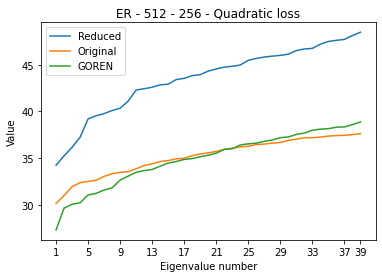

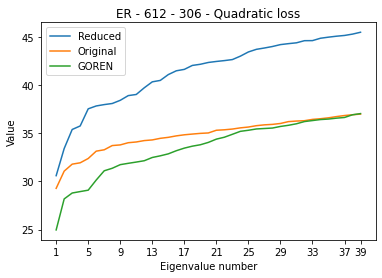

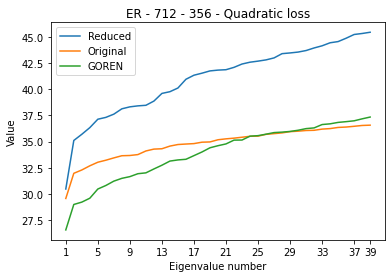

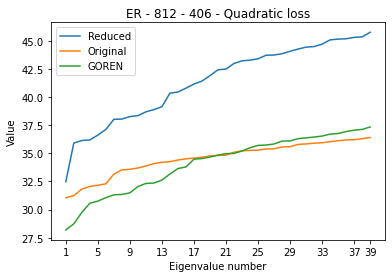

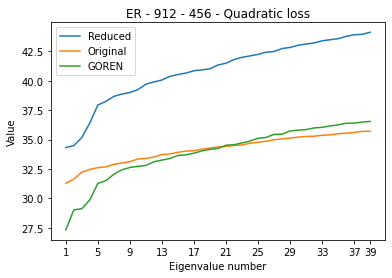

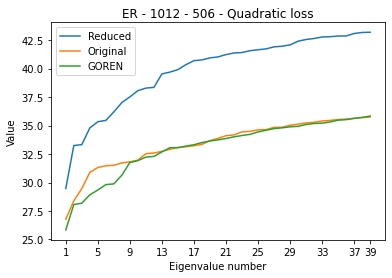

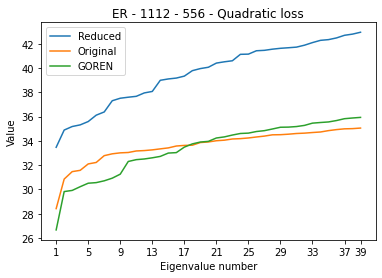

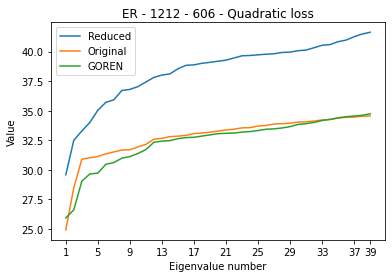

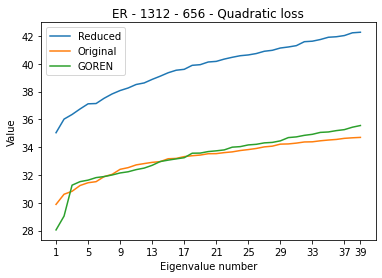

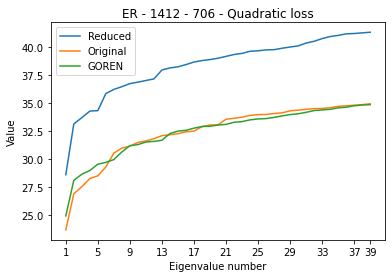

In [ ]:
# let's save the initial eigen values
for graphIndex in range(training_set.n_graphs):
  original_eigenerror, red_eigenvalues = GNN.eigen_error(training_set.graphs[graphIndex], training_set.reducedGraphs[graphIndex], training_set.reducedGraphs[graphIndex].weight_matrix)
  _, _, eigen_error, nn_eigenvalues = model.predictOnGraph(training_set, graphIndex, loss="quadratic_loss", laplacian="combinatorial")
  name = "ER - " + str(training_set.graphs[graphIndex].n_nodes) + " - " + str(training_set.reducedGraphs[graphIndex].n_supernodes) + " - " + fancy_loss_name[hyperparams["loss"]]
  plot_eigenvalues(red_eigenvalues, training_set.graphs[graphIndex].eigenvalues, nn_eigenvalues, name = name, savePath=subfolder+traingraph+"training_"+str(graphIndex)+".png")
 
for graphIndex in range(validation_set.n_graphs):
  original_eigenerror, red_eigenvalues = GNN.eigen_error(validation_set.graphs[graphIndex], validation_set.reducedGraphs[graphIndex], validation_set.reducedGraphs[graphIndex].weight_matrix)
  _, _, eigen_error, nn_eigenvalues = model.predictOnGraph(validation_set, graphIndex, loss="quadratic_loss", laplacian="combinatorial")
  name = "ER - " + str(validation_set.graphs[graphIndex].n_nodes) + " - " + str(validation_set.reducedGraphs[graphIndex].n_supernodes) + " - " + fancy_loss_name[hyperparams["loss"]]
  plot_eigenvalues(red_eigenvalues, validation_set.graphs[graphIndex].eigenvalues, nn_eigenvalues, name = name, savePath=subfolder+traingraph+"validation_"+str(graphIndex)+".png")

In [ ]:
def saveDatas(train_losses, val_improvements, val_losses, folder):
  np.savetxt(folder+"train_losses.csv", train_losses, delimiter=";")
  np.savetxt(folder+"val_improvements.csv", val_improvements, delimiter=";")
  np.savetxt(folder+"val_losses.csv", val_losses, delimiter=";")
 
def saveData(data, folder, name):
  np.savetxt(folder+name, data, delimiter=";")

## TRAINING

In [ ]:
train_losses = []
val_improvements = []
val_losses = []
train_losses_extra = []
train_improvements_extra = []
 
for train_graph_index in range(fromGraph, toGraph):
  file = open(subfolder+"best_val_imp.txt")
  best_val_imp = np.loadtxt(file, delimiter=";")
  file.close()
  try:
    model._import(subfolder+"best_so_far.pt")
  except:
    pass
  w_hat = training_set.reducedGraphs[train_graph_index].weight_matrix
  for e in range(hyperparams['n_epochs']):
    print("Training on graph:", train_graph_index, "--- Epoch:", e, end=" ")
    w_hat, LOSS = model.forwardOnGraph(training_set, train_graph_index, w_hat.detach().clone(), loss=hyperparams['loss'])
    print("--- Avg training loss:", LOSS, end=" ")
    tra_loss_avg, tra_imp_avg = model.validate(training_set_original_eigenerrors, training_set, loss=hyperparams['loss'], laplacian=hyperparams['laplacian'])
    val_loss_avg, val_imp_avg = model.validate(validation_set_original_eigenerrors, validation_set, loss=hyperparams['loss'], laplacian=hyperparams['laplacian'])
    print("--- Avg validation loss:", val_loss_avg, "--- Validation improvement: ", val_imp_avg, "%")
    if(val_imp_avg > best_val_imp):
      print("\t Saving the model so far..", end=" ")
      best_val_imp = val_imp_avg
      model.export(subfolder+"best_so_far.pt")
      np.savetxt(subfolder+"best_val_imp.txt", [best_val_imp])
 
    train_losses.append(LOSS)
    val_improvements.append(val_imp_avg)
    val_losses.append(val_loss_avg)
    train_losses_extra.append(tra_loss_avg)
    train_improvements_extra.append(tra_imp_avg)
 
model.export(subfolder+traingraph+"last_epoch_model.pt")
saveDatas(train_losses, val_improvements, val_losses, subfolder+traingraph)
saveData(train_losses_extra, subfolder+traingraph, "train_losses_extra.csv")
saveData(train_improvements_extra, subfolder+traingraph, "train_improvements_extra.csv")

Loading model:  /content/drive/MyDrive/USI/GDLProject/models/quadratic_loss/combinatorial/v6/best_so_far.pt
Training on graph: 4 --- Epoch: 0 --- Avg training loss: 17.726142760685512 --- Avg validation loss: 12.009798431396485 --- Validation improvement:  36.11437294060232 %
Training on graph: 4 --- Epoch: 1 --- Avg training loss: 22.786217880249023 --- Avg validation loss: 17.068109893798827 --- Validation improvement:  28.00909880868001 %
Training on graph: 4 --- Epoch: 2 --- Avg training loss: 16.875870513916016 --- Avg validation loss: 62.30424880981445 --- Validation improvement:  -1465.6114666170386 %
Training on graph: 4 --- Epoch: 3 --- Avg training loss: 26.368347072601317 --- Avg validation loss: 12.733500480651855 --- Validation improvement:  59.319550057240306 %
Training on graph: 4 --- Epoch: 4 --- Avg training loss: 13.187577513286046 --- Avg validation loss: 12.099560165405274 --- Validation improvement:  40.43825942181483 %
Training on graph: 4 --- Epoch: 5 --- Avg tra